### Step 0 : Init RoboFeeder Env
This cell sets up the environment for the RoboFeeder simulation by importing necessary modules and configuring the Python path.

In [ ]:
import os 
dir = os.getcwd()
if 'examples' in dir:
    os.chdir(os.getcwd().split('examples')[0])
else:
    print("please set the working directory to the root of the gym4ReaL repository")

# check if the current working directory is the root of the gym4ReaL repository
os.getcwd()

### Step 1 : Import Required Modules
This cell imports the necessary modules and updates the system path to include the gym4ReaL repository. It also imports the robot simulator and matplotlib for visualization purposes.

In [ ]:
import sys
sys.path.append(os.getcwd())  # <-- path to the *parent* of gym4real

import gym4real.envs.robofeeder.rf_picking_v1 as env
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation

### Step 2 : Test Simulator
import the simulator configuration file to pass the required parameters to run. 
Relevant parameters to adapt:

#### ObjectToPick
    NUMBER_OF_OBJECTS: 1           # (int) Number of objects to pick
    SHUFFLE_OBJECTS: True          # (bool) Shuffle object positions at reset
    OBJ_CORRECT_ORIENTATION: True  # (bool) Ensure objects have correct orientation

#### Simulator Setting
    IS_SIMULATION_REAL_TIME: False   # (bool) Run simulation in real time
    IS_SIMULATION_SHOWED: True       # (bool) Show simulation window
    IS_SIMULATION_RECORD: False      # (bool) Record simulation video
    RECORD_FOLDER : "." # (str) Folder to save recorded videos


In [ ]:
import shutil

# Copy the default configuration file to a new editable file
default_config_file = os.getcwd() + "/gym4real/envs/robofeeder/configuration.yaml"
config_file = os.getcwd() + "/examples/robofeeder/notebooks/configuration_editable.yaml"
shutil.copy(default_config_file, config_file)


### Step 3 : Initialize the RoboFeeder Environment
This cell creates an instance of the RoboFeeder environment using the editable configuration file. The environment is now ready for interaction and simulation.


In [ ]:
env = env.robotEnv(config_file)

### Step 4 : Define some utility functions.
- compute_camera_matrix(): Computes the camera projection matrix for the simulation.
- word2pixel(xyz_global): Converts world coordinates to pixel coordinates using the camera matrix.
- normalizeAngle(angle): Normalizes angles to a specific range.
- get_objs(): Retrieves object positions and orientations in pixel coordinates.
- showObs(obs): Displays an observation image using matplotlib.

In [3]:
def compute_camera_matrix():
  model = env.simulator.model
  data = env.simulator.data
  renderer = env.simulator.renderer
  renderer.update_scene(data,camera="top_down")
  pos = np.mean([camera.pos for camera in renderer.scene.camera], axis=0)
  z = -np.mean([camera.forward for camera in renderer.scene.camera], axis=0)
  y = np.mean([camera.up for camera in renderer.scene.camera], axis=0)
  rot = np.vstack((np.cross(y, z), y, z))
  fov = model.cam('top_down').fovy[0]

  # Translation matrix (4x4).
  translation = np.eye(4)
  translation[0:3, 3] = -pos

  # Rotation matrix (4x4).
  rotation = np.eye(4)
  rotation[0:3, 0:3] = rot

  # Focal transformation matrix (3x4).
  focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * renderer.height / 2.0
  focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]

  # Image matrix (3x3).
  image = np.eye(3)
  image[0, 2] = (renderer.width - 1) / 2.0
  image[1, 2] = (renderer.height - 1) / 2.0
  return image @ focal @ rotation @ translation

def word2pixel(xyz_global):
    cam_matrix = compute_camera_matrix()
    # Camera matrices multiply homogenous [x, y, z, 1] vectors.
    corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
    corners_homogeneous[:3, :] = xyz_global
    # Get the camera matrix.
    xs, ys, s = cam_matrix @ corners_homogeneous
    # x and y are in the pixel coordinate system.
    x = xs / s
    y = ys / s
    return x,y


def normalizeAngle(angle):
    if(angle>np.pi):angle -=np.pi
    elif(angle<0):angle += np.pi
    return angle


def get_objs(): # list(x,y,rot)
    initialObjPos=[]
    for i in range(env.simulator.configs["NUMBER_OF_OBJECTS"]):
        # get the position of the obj from the site in the right position (+1 due to the target (goal) site)
        coords = env.simulator.data.site(1+i).xpos.copy()
        pixelCoord = word2pixel(np.array([coords[0],coords[1],coords[2]]).reshape(3,1))
        rot = Rotation.from_quat(env.simulator.data.qpos[0+7*i+3:7*(i+1)].copy()).as_euler('xyz')
        rot = normalizeAngle(2.35+rot[0])
        initialObjPos.append((pixelCoord[0][0],pixelCoord[1][0],rot))
    return initialObjPos


def showObs(obs):
    plt.imshow(obs.transpose(1,2,0))
    plt.gray()
    plt.show()



### Side View Camera Visualization


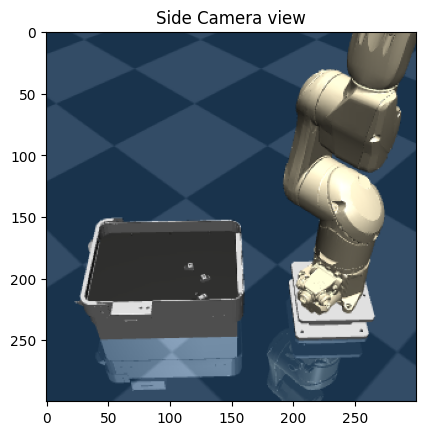

In [ ]:

env.simulator.renderer.update_scene(env.simulator.data, camera="angled_side_view")
frame = env.simulator.renderer.render()
plt.title("Side Camera view")
plt.imshow(frame)


### Top View Camera Visualization
This cell renders and displays the top-down camera view from the simulator using matplotlib.


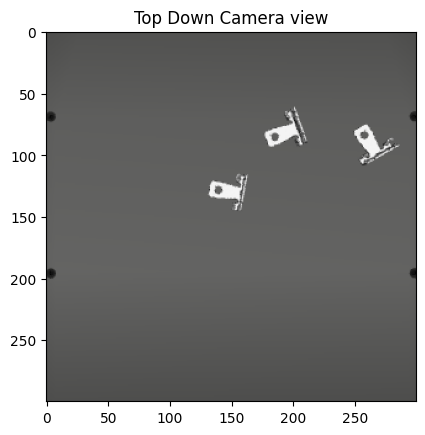

In [5]:
### TOP VIEW CAMERA ###
env.simulator.renderer.update_scene(env.simulator.data, camera="top_down")
frame = env.simulator.renderer.render()
plt.title("Top Down Camera view")
plt.imshow(frame)


### Step 5a : Run Random Actions
This cell resets the environment, performs a random action, displays the observation, and prints the reward and done status. If the episode is done, it resets the environment again.


In [6]:
# perform a random action
env.reset()
action = env.action_space.sample()
print("action:",action)
action = np.array(action)
obs,rew,done,_,_ = env.step(action)

print("done:",done) 
print("reward:",rew,"\n")

if(done): env.reset()

# print the obs after the action
#showObs(env.current_obs)

action: [-0.12743224  0.63747764 -0.50500983]
done: False
reward: -1 



### Step 5b : Run Correct Actions
This cell resets the environment, performs a correct action to pick the object, displays the observation, and prints the reward and done status. If the episode is done, it resets the environment again.


In [7]:
env.reset()
obj = get_objs()
obj_to_pick= env.simulator.configs["NUMBER_OF_OBJECTS"]

for i in range(obj_to_pick):
    #normalize the coordinates between [-1,1]
    coordinates = np.array(obj[i][0:2])/(env.simulator.configs["OBSERVATION_IMAGE_DIM"]/2) -1 
    rot = obj[i][2]/(np.pi/2)-1

    obs, reward, done,_,info = env.step(np.append(coordinates,rot))
    print("Rew:",reward)
    print("done",done)
    

Rew: -0.19899999999999995
done False
Rew: 1
done False
Rew: 1
done False



### Step 6 : Record Simulation Video
This cell checks if simulation recording is enabled in the simulator configuration. If enabled, it constructs the video path and displays the recorded simulation video in the notebook using an HTML video player.


In [17]:
import os
from IPython.display import HTML

if env.simulator.configs["IS_SIMULATION_RECORD"]:
    # Construct video path
    video_name = f"simulated_pick_{env.simulator.counter}.mp4"
    video_path = os.path.join(env.simulator.configs["RECORD_FOLDER"], video_name)
    
    display(HTML(f"""
    <div style="text-align: center;">
        <video width="300" height="300" controls>
            <source src="{video_path}" type="video/mp4">
            Your browser does not support the video tag.
        </video>
    </div>
    """))